#### Nicolás García Gómez - DS 61

# Proyecto 03 - Procesamiento del Lenguaje Natural

## Dataset: The Multilingual Amazon Reviews Corpus

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Es un archivo .zip que contiene tres documentos. Más información sobre el dataset [aquí](https://registry.opendata.aws/amazon-reviews-ml/). Es importante que tengas en cuenta la [licencia](https://docs.opendata.aws/amazon-reviews-ml/license.txt) de este dataset.**

### Exploración de datos y Procesamiento del Lenguaje Natural

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Considera que hasta que no hayas aplicado las herramientas de Procesamiento del Lenguaje Natural vistas, será difícil completar este análisis. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿qué palabras están asociadas a calificaciones positivas y qué palabras a calificaciones negativas?

### Machine Learning

Implementa un modelo que, dada la crítica de un producto, asigne la cantidad de estrellas correspondiente. **Para pensar**: ¿es un problema de Clasificación o de Regresión?

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?

**Recomendación:** si no te resulta conveniente trabajar en español con NLTK, te recomendamos que explores la librería [spaCy](https://spacy.io/).

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Valdrá la pena convertir el problema de Machine Learning en un problema binario? Es decir, asignar únicamente las etiquetas Positiva y Negativa a cada crítica y hacer un modelo que, en lugar de predecir las estrellas, prediga esa etiqueta. Pensar en qué situación puede ser útil. ¿Esperas que el desempeño sea mejor o peor?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

**IMPORTANTE**:
**POR QUE HAY TRES DATA SET** => A veces los datasets de problemas de machine learning se pre-splitean en train, dev y test para garantizar que los resultados sean reproducibles (se entrena con train y se testea con test). El otro split "dev" se usa para tunear los hiperparámetros del modelo, o, cuando el modelo lo permite, ajustar los parámetros en el entrenamiento con una función de costo para dev.  **Bajo esa modalidad el workflow sería: entrenar con train -> ajustar hiperparámetros contra dev -> medir performance (y capacidad de generalización) con test**

In [1]:
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter # para dar formato de porcentaje a las tablas de frecuencia
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

## 1. Exploración del dataset - EDA

**Consultamos los 3 data set**
- DEV
- TEST
- TRAIN

In [2]:
Amazon_dev = pd.read_json('dataset_es_dev.json', lines=True) # para abir un archivo tipo JSON
Amazon_dev.head()
Amazon_dev.shape # 5000 x 8

(5000, 8)

In [3]:
Amazon_test = pd.read_json('dataset_es_test.json', lines=True) # para abir un archivo tipo JSON
Amazon_test.head()
Amazon_test.shape

(5000, 8)

In [2]:
Amazon_train = pd.read_json('dataset_es_train.json', lines=True) # para abir un archivo tipo JSON
Amazon_train.head()
Amazon_train.shape

(200000, 8)

In [5]:
Amazon_train.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0491108,product_es_0296024,reviewer_es_0999081,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,es,electronics
1,es_0869872,product_es_0922286,reviewer_es_0216771,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,es,electronics
2,es_0811721,product_es_0474543,reviewer_es_0929213,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,es,drugstore
3,es_0359921,product_es_0656090,reviewer_es_0224702,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,es,wireless
4,es_0068940,product_es_0662544,reviewer_es_0224827,1,Llega tarde y co la talla equivocada,Devuelto,es,shoes


In [6]:
#Contamos cantidad de registros por columna
Amazon_train.count()

review_id           200000
product_id          200000
reviewer_id         200000
stars               200000
review_body         200000
review_title        200000
language            200000
product_category    200000
dtype: int64

In [7]:
# No hay valore NAN
Amazon_train.isna().sum()

review_id           0
product_id          0
reviewer_id         0
stars               0
review_body         0
review_title        0
language            0
product_category    0
dtype: int64

In [8]:
# No hay valores nulos
Amazon_train.isnull().sum() 

review_id           0
product_id          0
reviewer_id         0
stars               0
review_body         0
review_title        0
language            0
product_category    0
dtype: int64

In [9]:
#Tipo de Datos
Amazon_train.dtypes

review_id           object
product_id          object
reviewer_id         object
stars                int64
review_body         object
review_title        object
language            object
product_category    object
dtype: object

In [10]:
Amazon_train.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   review_id         200000 non-null  object
 1   product_id        200000 non-null  object
 2   reviewer_id       200000 non-null  object
 3   stars             200000 non-null  int64 
 4   review_body       200000 non-null  object
 5   review_title      200000 non-null  object
 6   language          200000 non-null  object
 7   product_category  200000 non-null  object
dtypes: int64(1), object(7)
memory usage: 12.2+ MB


In [11]:
#No tenemos filas duplicadas en el data set
Amazon_train.duplicated()
print('number of duplicate rows: ', Amazon_train[Amazon_train.duplicated()].shape[0])

number of duplicate rows:  0


In [12]:
#Tenemos solo 5 valores posibles para las estrellas del 1 al 5
pd.unique(Amazon_train['stars'])
#Amazon_train['stars'].unique()

array([1, 2, 3, 4, 5], dtype=int64)

In [3]:
# revisamos los valores únicos de cada una de las columnas del data set. 

for col in Amazon_train.columns:
    print(col, len(Amazon_train[col].unique()), 'valore diferentes')

review_id 200000 valore diferentes
product_id 150938 valore diferentes
reviewer_id 179076 valore diferentes
stars 5 valore diferentes
review_body 198264 valore diferentes
review_title 112114 valore diferentes
language 1 valore diferentes
product_category 30 valore diferentes


- **Elimino columnas que entiendo no voy a necesitar**
 - 'review_id': es un id con el que no puedo caractrerizar la review
 - 'product_id':  es un id con el que no puedo caracterizar al producto y saber por ejemplo algunas de sus caracteristicas
 - 'reviewer_id':es un id con el que no puedo caracterizar la review
 - 'language': todo en un único idioma

In [4]:
Amazon_train.columns

Index(['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body',
       'review_title', 'language', 'product_category'],
      dtype='object')

In [ ]:
Amazon_train.drop(['review_id','product_id','reviewer_id','language'], axis=1, inplace= True)

- **Mantenemos las columnas** 
  - Stars
  - Review body
  - Review title
  - Product Category

In [7]:
Amazon_train.head()

,stars,review_body,review_title,product_category
0,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,electronics
1,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,electronics
2,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,drugstore
3,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,wireless
4,1,Llega tarde y co la talla equivocada,Devuelto,shoes


- **Revisamos el largo en cantidad de caracteres de las diferentes reviews**

In [17]:
Amazon_train['length']= Amazon_train['review_body'].apply(len)

In [18]:
Amazon_train[['review_body','length']].head()

,review_body,length
0,Nada bueno se me fue ka pantalla en menos de 8...,94
1,"Horrible, nos tuvimos que comprar otro porque ...",140
2,Te obligan a comprar dos unidades y te llega s...,117
3,"No entro en descalificar al vendedor, solo pue...",332
4,Llega tarde y co la talla equivocada,36


In [19]:
#Aplicamos .describe() a las dos variables núnmericas

Amazon_train.describe()

,stars,length
count,200000.000000,200000.000000
mean,3.000000,151.302910
std,1.414217,132.201785
min,1.000000,16.000000
25%,2.000000,68.000000
50%,3.000000,120.000000
75%,4.000000,186.000000
max,5.000000,3086.000000


Text(0.5, 1.0, 'Distribución de la variable length')

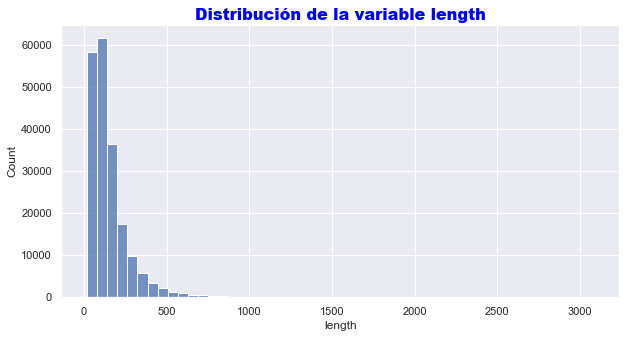

In [20]:
#Vemos la distribución de 'length'

plt.figure(figsize = (10,5))
sns.histplot(Amazon_train['length'], bins =50)
plt.title('Distribución de la variable length', fontweight= 'black',fontsize = 16,color="blue")

<AxesSubplot:xlabel='length'>

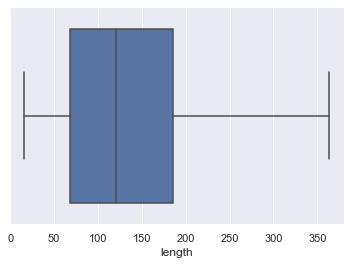

In [21]:
sns.boxplot(x ='length',data = Amazon_train, showfliers = False)
#showfliers => If False, suppress the plotting of outliers

Como se observa en la tabla y el gráfico podemos ver que, 
 - El 50% de las reviews tienen menos de 120 caracteres
 - El 75% de las reviews tienen menos de 186 caracteres

- Revisamos el largo en cantidad de caracteres de las diferentes reviews en función de las estrellas y vemos una distribución similar etre las diferentes clasificaciones

<AxesSubplot:xlabel='stars', ylabel='length'>

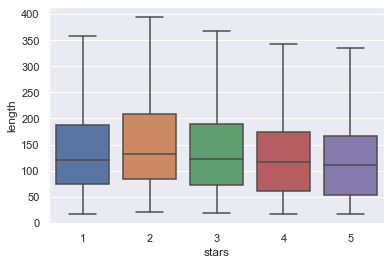

In [22]:
sns.boxplot(x ='stars' , y = 'length',data = Amazon_train, showfliers = False)
#showfliers => If False, suppress the plotting of outliers

- Observada esta concentración del data set le doy un vistazo a aquellas review de gran longitud. 

In [23]:
# Reviews de gran longitud

Amazon_train[['review_body','length','stars']].sort_values('length',ascending=False).head()

,review_body,length,stars
192038,"Hago estos cambios en mi opinión, no por el pr...",3086,5
69098,Compré esta depiladora recomendada por una ami...,2898,2
44542,La idea de este producto está bastante bien: m...,2727,2
108629,"La linterna funciona muy bien, en términos gen...",2459,3
176581,La idea era comprar un radio reloj despertador...,2392,5


In [24]:
Amazon_train[Amazon_train['length']==2898]

,stars,review_body,review_title,product_category,length
69098,2,Compré esta depiladora recomendada por una ami...,"Resultados regulares, sensor muy mejorable",personal_care_appliances,2898


In [ ]:
# a modo de curisosidad miro los 5 casos con review más extensas => 3086 / 2898 / 2727 / 2459 / 2392
Amazon_train[Amazon_train['length']==2898]['review_body'].iloc[0]

- Revisamos otros datos descriptivos en el siguiente chart haciendo foco en el title, body y category
 - Acá nos damos cuenta que el titulo puede ser un  muy buen predictor al revisar el 'top' y su 'freq '
      - 1 estrella => 'mala calidad'
      - 2 estrella => 'Regular'
      - 3 estrella => 'bien'
      - 4 estrella => 'bien'
      - 5 estrella => 'perfecto'
 - En cambio el review body
      - 1 estrella => 'no he recibido el producto'
      - 2 estrella => 'no es lo que esperaba'
      - 3, 4 y 5 estrella => 'buena relación calidad precio'

In [26]:
Amazon_train.drop(['length'], axis=1, inplace= True)

In [27]:
Amazon_train.groupby('stars').describe().transpose()

stars                                             1                      2  \
review_body      count                        40000                  40000   
                 unique                       39800                  39909   
                 top     No he recibido el producto  No es lo que esperaba   
                 freq                            15                     21   
review_title     count                        40000                  40000   
                 unique                       24965                  28158   
                 top                   Mala calidad                Regular   
                 freq                           597                    542   
product_category count                        40000                  40000   
                 unique                          30                     30   
                 top                       wireless               wireless   
                 freq                          6283                   5684   

stars                                                3  \
review_body      count                           40000   
                 unique                          39839   
                 top     Buena relación calidad precio   
                 freq                               15   
review_title     count                           40000   
                 unique                          27217   
                 top                              Bien   
                 freq                              701   
product_category count                           40000   
                 unique                             30   
                 top                              home   
                 freq                             5477   

stars                                                4  \
review_body      count                           40000   
                 unique                          39585   
                 top     Buena relación calidad precio   
                 freq                               57   
review_title     count                           40000   
                 unique                          22917   
                 top                              Bien   
                 freq                              869   
product_category count                           40000   
                 unique                             30   
                 top                              home   
                 freq                             5309   

stars                                                5  
review_body      count                           40000  
                 unique                          39602  
                 top     Buena relación calidad precio  
                 freq                               32  
review_title     count                           40000  
                 unique                          21390  
                 top                          Perfecto  
                 freq                             1361  
product_category count                           40000  
                 unique                             30  
                 top                              home  
                 freq                             5243

- Revisando los titulos vemos que los primeros 10 con más repitición denotan una conotación positiva. Igualmente esto es solo indicativo

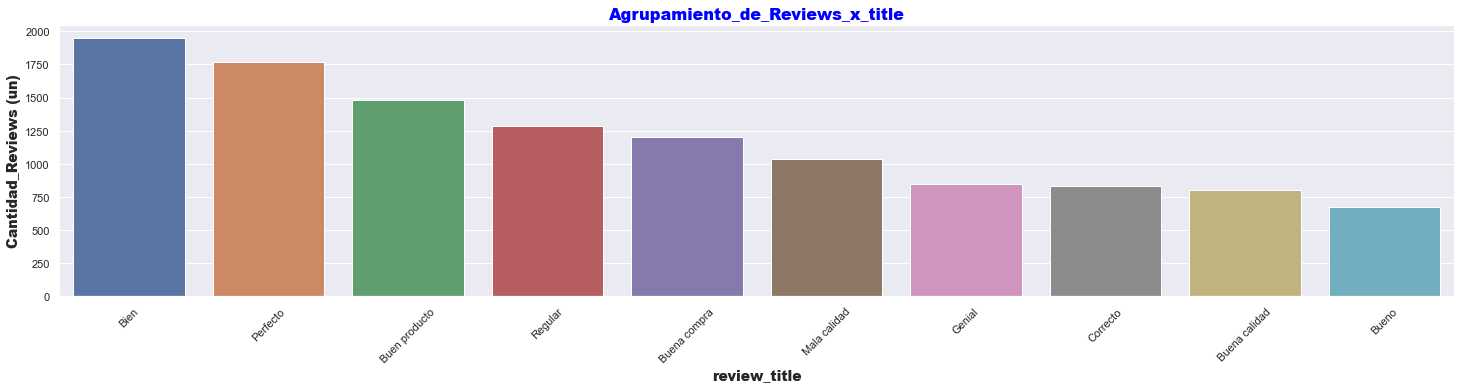

<Figure size 432x288 with 0 Axes>

In [28]:
plt.figure(figsize=(25, 5))

ax=sns.countplot( x = 'review_title',data = Amazon_train, order= Amazon_train ['review_title'].value_counts().head(10).index)

plt.xticks(rotation = 45)
plt.yticks(rotation = 0)
plt.ylabel('Cantidad_Reviews (un)',fontweight= "black", fontsize = 14)
plt.xlabel('review_title',fontweight= "black", fontsize = 14)
plt.title('Agrupamiento_de_Reviews_x_title',fontweight= "black",fontsize = 16, color="blue")
# plt.grid()
plt.figure()
plt.show()

- **Análizamos las categorías**

In [29]:
#Agrupamos las review en función del product_category
 
print('Agrupamiento de reviews por categoría')
print('')
Amazon_train.groupby(['product_category']).size().reset_index(name='Cantidad_ reviews_x_categoría').sort_values('Cantidad_ reviews_x_categoría',ascending=False).head(10)
#Amazon_dev['product_category'].value_counts()

Agrupamiento de reviews por categoría



,product_category,Cantidad_ reviews_x_categoría
11,home,26962
29,wireless,25886
26,toy,13647
25,sports,13189
21,pc,11191
12,home_improvement,10879
8,electronics,10385
3,beauty,7337
1,automotive,7143
15,kitchen,6695


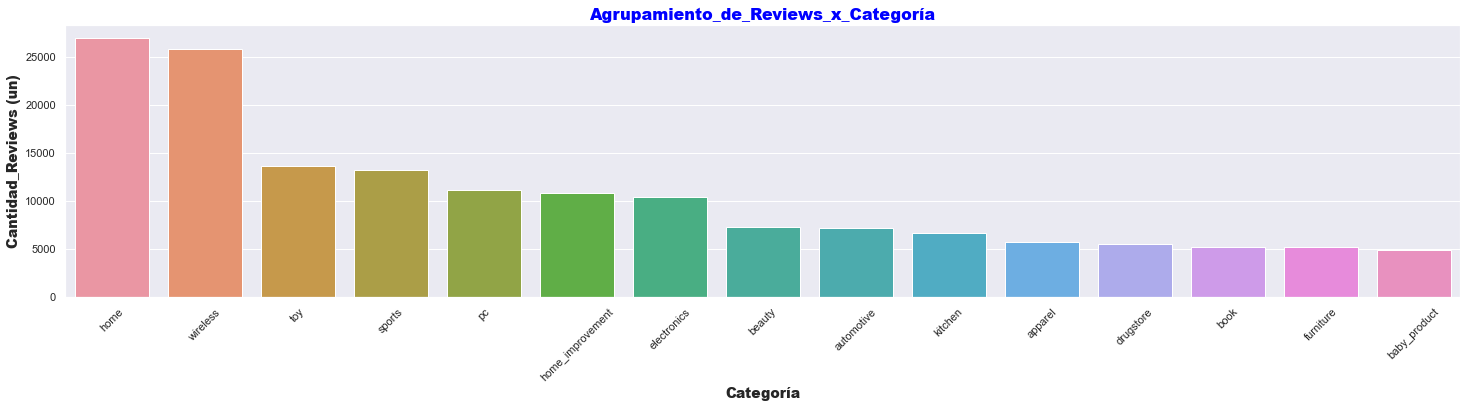

<Figure size 432x288 with 0 Axes>

In [30]:
#Armamos grafico en Seaborn para acompañar a la tabla de agrupamiento del punto anterior y visualizamos las primeras 15 categorías que como vasmos a ver debajo acumulan el 80% de las reviews
print('')
plt.figure(figsize=(25, 5))

ax=sns.countplot( x = 'product_category',data = Amazon_train, order= Amazon_train ['product_category'].value_counts().head(15).index)

plt.xticks(rotation = 45)
plt.yticks(rotation = 0)
plt.ylabel('Cantidad_Reviews (un)',fontweight= "black", fontsize = 14)
plt.xlabel('Categoría',fontweight= "black", fontsize = 14)
plt.title('Agrupamiento_de_Reviews_x_Categoría',fontweight= "black",fontsize = 16, color="blue")
# plt.grid()
plt.figure()
plt.show()

- **Armamos la tabla de frecuencias** absolutas, relativas, acumuladas y un grafico de Pareto para las Categorías => video: https://www.youtube.com/watch?v=NpEPEIMvItw

In [31]:
#Agrupamiento por product_category
frec = pd.value_counts(Amazon_train['product_category'])

#transformo en el df de poandas
df_frec= pd.DataFrame(frec)

#agrego columnas 'Frec_abs'
df_frec.columns = ['Frec_abs']

#calculo la coliumna 'Frec_abs'
df_frec['Frec_rel_%'] = 100* (df_frec.Frec_abs / Amazon_train.shape[0])

#tabla de frecuencias absolutas / reltivas / acumulada

frec_rel_val= df_frec['Frec_rel_%'].values # es una lista que contiene los valores de frec_rel_%

acum = []
valor_acum = 0

for i in frec_rel_val:
    valor_acum = valor_acum + i 
    acum.append(valor_acum)

df_frec['frec_rel_%_acum'] = acum
df_frec.head(15) # son las 15 categorías que acumulan el 80% de las review

,Frec_abs,Frec_rel_%,frec_rel_%_acum
home,26962,13.4810,13.4810
wireless,25886,12.9430,26.4240
toy,13647,6.8235,33.2475
sports,13189,6.5945,39.8420
pc,11191,5.5955,45.4375
home_improvement,10879,5.4395,50.8770
electronics,10385,5.1925,56.0695
beauty,7337,3.6685,59.7380
automotive,7143,3.5715,63.3095
kitchen,6695,3.3475,66.6570


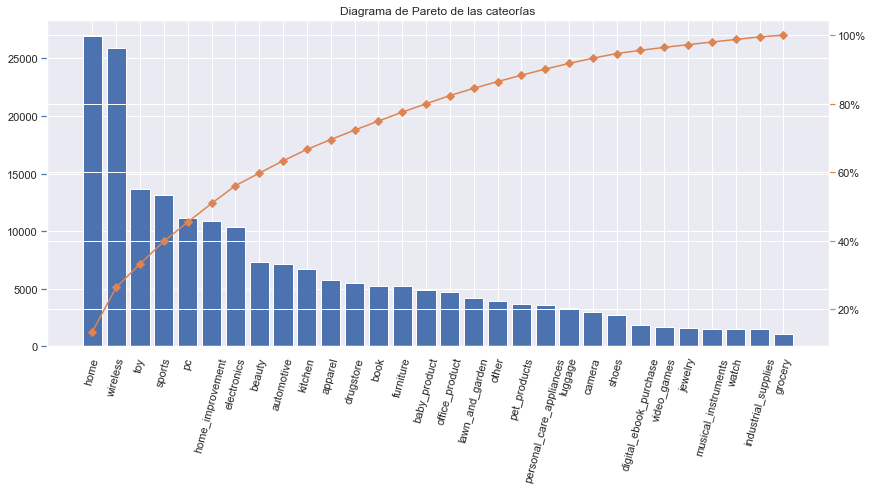

In [32]:
fig= plt.figure (figsize = (14,6))
ax= fig.add_subplot(1,1,1)

#Asignamos el titulo
ax.set_title ('Diagrama de Pareto de las cateorías')

#Creamos un grafico de barras con la frec_abs
ax.bar (df_frec.index, df_frec['Frec_abs'], color='C0')
        
    
#Graficamos la 'frec_rel_%_acum'
ax2 = ax.twinx() # generamos un nuevo eje
ax2.plot (df_frec.index, df_frec['frec_rel_%_acum'], color ='C1', marker='D', ms=5)
ax2.yaxis.set_major_formatter (PercentFormatter()) # para que los numeros del eje de la derecha esten en %

#Etiquetamos, asignamos color y damos rotación a las etiquetes de los ejes
ax.tick_params (axis='y', color = 'C0')
ax2.tick_params (axis='y', color = 'C1')
ax.set_xticklabels(df_frec.index, rotation=75)

plt.show()


Podemos concluir de las tablas y del pareto que, 
* El 80% de las review corresponden a 15 categorías =>  home, wireless, toy, sports, PC, home, electronics, beauty, automotive, kitchen, apparel,drugstore, book, furnitur and baby_products

- **Revisamos las review en función de la cantidad de estrellas, de 5 a 1**
 - Vemos que la cantidad de reviews es de la misma cantidad segun la clasiicación de las entrellas del 1 al 5

Agrupamiento de review por cantidad de estrellas

   stars  Cantidad_ reviews_x_estrella
0      1                         40000
1      2                         40000
2      3                         40000
3      4                         40000
4      5                         40000



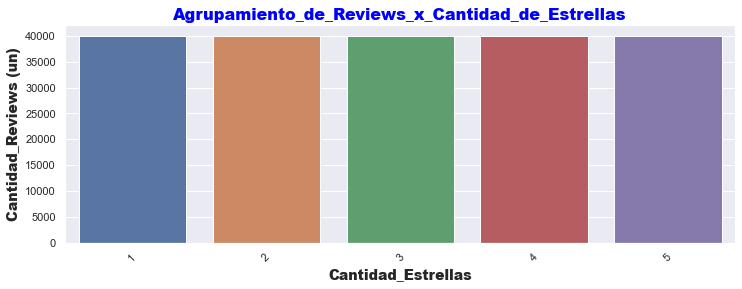

<Figure size 432x288 with 0 Axes>

In [33]:
print('Agrupamiento de review por cantidad de estrellas')
print('')
print(Amazon_train.groupby(['stars']).size().reset_index(name='Cantidad_ reviews_x_estrella').sort_values('Cantidad_ reviews_x_estrella',ascending=False))

#Armamos grafico en Seaborn para acompañar a la tabla de agrupamiento del punto anterior
print('')
plt.figure(figsize=(12, 4))

ax=sns.countplot( x = 'stars',data = Amazon_train)

plt.xticks(rotation = 45)
plt.yticks(rotation = 0)
plt.ylabel('Cantidad_Reviews (un)',fontweight= "black", fontsize = 14)
plt.xlabel('Cantidad_Estrellas',fontweight= "black", fontsize = 14)
plt.title('Agrupamiento_de_Reviews_x_Cantidad_de_Estrellas',fontweight= "black",fontsize = 16, color="blue")
#plt.legend(loc='lower center', shadow=False, fontsize='small')
#plt.grid()
plt.figure()
plt.show()

In [34]:
#Todas las estrellas (1 a 5)
Amazon_train_todos=Amazon_train.groupby([ 'stars','product_category']).size().reset_index(name='Cantidad_ reviews_x_categoría').sort_values(['stars','Cantidad_ reviews_x_categoría'],ascending=False)
Amazon_train_todos.head(50)

,stars,product_category,Cantidad_ reviews_x_categoría
131,5,home,5243
149,5,wireless,4516
146,5,toy,2827
145,5,sports,2512
141,5,pc,2455
132,5,home_improvement,2167
128,5,electronics,1932
124,5,book,1605
123,5,beauty,1423
135,5,kitchen,1323


In [35]:
# 5 estrellas
Amazon_train_5=Amazon_train[Amazon_train.stars ==5].groupby([ 'stars','product_category']).size().reset_index(name='Cantidad_ reviews_x_categoría').sort_values('Cantidad_ reviews_x_categoría',ascending=False)
Amazon_train_5.head(6)

,stars,product_category,Cantidad_ reviews_x_categoría
11,5,home,5243
29,5,wireless,4516
26,5,toy,2827
25,5,sports,2512
21,5,pc,2455
12,5,home_improvement,2167


In [36]:
# 4 estrellas
Amazon_train_4=Amazon_train[Amazon_train.stars ==4].groupby([ 'stars','product_category']).size().reset_index(name='Cantidad_ reviews_x_categoría').sort_values('Cantidad_ reviews_x_categoría',ascending=False)
Amazon_train_4.head()

,stars,product_category,Cantidad_ reviews_x_categoría
11,4,home,5309
29,4,wireless,4606
25,4,sports,2860
26,4,toy,2639
21,4,pc,2379


In [37]:
# 3 estrellas
Amazon_train_3=Amazon_train[Amazon_train.stars ==3].groupby([ 'stars','product_category']).size().reset_index(name='Cantidad_ reviews_x_categoría').sort_values('Cantidad_ reviews_x_categoría',ascending=False)
Amazon_train_3.head(6)

,stars,product_category,Cantidad_ reviews_x_categoría
11,3,home,5477
29,3,wireless,4797
26,3,toy,2965
25,3,sports,2828
12,3,home_improvement,2188
21,3,pc,1988


In [38]:
# 2 estrellas
Amazon_train_2=Amazon_train[Amazon_train.stars ==2].groupby([ 'stars','product_category']).size().reset_index(name='Cantidad_ reviews_x_categoría').sort_values('Cantidad_ reviews_x_categoría',ascending=False)
Amazon_train_2.head(6)

,stars,product_category,Cantidad_ reviews_x_categoría
29,2,wireless,5684
11,2,home,5542
26,2,toy,2713
25,2,sports,2551
8,2,electronics,2188
21,2,pc,2149


In [39]:
# 1 estrellas
Amazon_train_1=Amazon_train[Amazon_train.stars ==1].groupby([ 'stars','product_category']).size().reset_index(name='Cantidad_ reviews_x_categoría').sort_values('Cantidad_ reviews_x_categoría',ascending=False)
Amazon_train_1.head(6)

,stars,product_category,Cantidad_ reviews_x_categoría
29,1,wireless,6283
11,1,home,5391
26,1,toy,2503
25,1,sports,2438
8,1,electronics,2402
21,1,pc,2220


Podemos concluir de las tablas que, 

- Al revisar cantidad de reviews en función de la categoría encontramos una distribución homogena debido a que las categorías => 'wireless', 'home', 'sports' ´toy´, 'PC', 'electronics' son las 6 que aparecen en cada categoría de estrellas (de 1 a 5)

### A modo de una revisión más exaustivo del data set ejecutamos => 'PANDAS-PROFILING'

In [ ]:
pip install pandas-profiling 

In [ ]:
from pandas_profiling import ProfileReport
profile = ProfileReport(Amazon_test,title='Reporte Análisis Exploratorio',html={'style':{'full_width':True}})
profile.to_file("Amazon_test_EDA.html")#extraigo 

In [ ]:
#visualizo el EDA en el mismo note book
profile

**Conclusiones del EDA y pandas-profiling** 
- Tenemos un data set 'Muy balanceado',es decir, las review se separan de manera equilibrada en función de la clasificación de las estrellas y dentro de cada putuación de estrellas (1-5) la distribuciuón de las categorías tambien esta balanceada
- El data set no presenta valores nulos, ni duplicados, ni campos vacíos
- El 'review title' parece un buen indicador para la determinación de las estrellas

## 2.NLTK

## 2.1 NORMALIZACIÓN
- 2.1.0 Trabajamos sobre las 'Stops Words'
- 2.1.1 'corro las fuciones clean_text_round1 y clean_text_round2'
- 2.1.2 'pasamos texto a minuscula' 
- 2.1.3 'tokenizar' 
- 2.1.4 'limpiar caracteres'
- 2.1.5 'quitar acentos'
- 2.1.6 'quitar stopwords' 
- 2.1.7 'quito palabas con menos de tres caracteres'
- 2.1.8 Llevamos las palabras a su raíz

In [ ]:
import nltk # librería para NLP
#Para configurar NLTK. 
nltk.download('punkt')
nltk.download('stopwords') # aca descargamos las stop words, una lista predefinida de la librería
from nltk.corpus import stopwords
import re# Importamos esta libreria que nos permite reemplzar caracteres
import string

In [9]:
Amazon_train.head()

,stars,review_body,review_title,product_category
0,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,electronics
1,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,electronics
2,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,drugstore
3,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,wireless
4,1,Llega tarde y co la talla equivocada,Devuelto,shoes


In [10]:
#Armo un data set con las columnas que considero centrales y en el orden que me parece mejor => titulo del review, cuerpo del review y la clasificación del 1 al 5 con estrellas

Amazon_train_concat = pd.concat([Amazon_train.review_title,Amazon_train.review_body,Amazon_train.product_category,Amazon_train.stars],axis=1)
Amazon_train_concat.head()

,review_title,review_body,product_category,stars
0,television Nevir,Nada bueno se me fue ka pantalla en menos de 8...,electronics,1
1,Dinero tirado a la basura con esta compra,"Horrible, nos tuvimos que comprar otro porque ...",electronics,1
2,solo llega una unidad cuando te obligan a comp...,Te obligan a comprar dos unidades y te llega s...,drugstore,1
3,PRODUCTO NO RECIBIDO.,"No entro en descalificar al vendedor, solo pue...",wireless,1
4,Devuelto,Llega tarde y co la talla equivocada,shoes,1


In [11]:
#Renombramos las columnas

Amazon_train_concat=Amazon_train_concat.rename(columns={'review_title':'title','review_body':'body', 'product_category':'category'})
Amazon_train_concat.head()

,title,body,category,stars
0,television Nevir,Nada bueno se me fue ka pantalla en menos de 8...,electronics,1
1,Dinero tirado a la basura con esta compra,"Horrible, nos tuvimos que comprar otro porque ...",electronics,1
2,solo llega una unidad cuando te obligan a comp...,Te obligan a comprar dos unidades y te llega s...,drugstore,1
3,PRODUCTO NO RECIBIDO.,"No entro en descalificar al vendedor, solo pue...",wireless,1
4,Devuelto,Llega tarde y co la talla equivocada,shoes,1


 - **Función de eliminación de acentos**

In [12]:
#funci+on para eliminación de acentos

def eliminar_acentos(string):
    """
    DESCRIPCION: Eliminar acentos de una cadena de texto
    PARAMS:
    * string (string): Cadena de texto
    RETURN:
    * Cadena de texto sin acentos
    """
    trans = str.maketrans('ÁÉÍÓÚÜáéíóúü','AEIOUUaeiouu')
    return string.translate(trans)

### - **2.1.0 Trabajamos sobre las 'Stops Words'**

In [13]:
#Stopswords en español
stopwords = set(nltk.corpus.stopwords.words('spanish'))
stopwords = nltk.corpus.stopwords.words('spanish') # lo transformo en una lista de np
stopwords # no hay mayusculas y si hay acentos... 

['de',
 'la',
 'que',
 'el',
 'en',
 'y',
 'a',
 'los',
 'del',
 'se',
 'las',
 'por',
 'un',
 'para',
 'con',
 'no',
 'una',
 'su',
 'al',
 'lo',
 'como',
 'más',
 'pero',
 'sus',
 'le',
 'ya',
 'o',
 'este',
 'sí',
 'porque',
 'esta',
 'entre',
 'cuando',
 'muy',
 'sin',
 'sobre',
 'también',
 'me',
 'hasta',
 'hay',
 'donde',
 'quien',
 'desde',
 'todo',
 'nos',
 'durante',
 'todos',
 'uno',
 'les',
 'ni',
 'contra',
 'otros',
 'ese',
 'eso',
 'ante',
 'ellos',
 'e',
 'esto',
 'mí',
 'antes',
 'algunos',
 'qué',
 'unos',
 'yo',
 'otro',
 'otras',
 'otra',
 'él',
 'tanto',
 'esa',
 'estos',
 'mucho',
 'quienes',
 'nada',
 'muchos',
 'cual',
 'poco',
 'ella',
 'estar',
 'estas',
 'algunas',
 'algo',
 'nosotros',
 'mi',
 'mis',
 'tú',
 'te',
 'ti',
 'tu',
 'tus',
 'ellas',
 'nosotras',
 'vosotros',
 'vosotras',
 'os',
 'mío',
 'mía',
 'míos',
 'mías',
 'tuyo',
 'tuya',
 'tuyos',
 'tuyas',
 'suyo',
 'suya',
 'suyos',
 'suyas',
 'nuestro',
 'nuestra',
 'nuestros',
 'nuestras',
 'vuestro'

In [14]:
#quito los acentos en mi lista de stopswords y me aseguro de que todo este en minuscula
stopwords_modificada = []
for i in range (len(stopwords)):
    stop= stopwords[i]
    stop=stop.lower()
    stop= nltk.tokenize.RegexpTokenizer('[\w]+').tokenize(stop)# Tokeniza
    stop= [eliminar_acentos(w) for w in stop]
    stopwords_modificada.append(stop)
stopwords_modificada = list(itertools.chain(*stopwords_modificada))

In [15]:
stopwords_modificada

['de',
 'la',
 'que',
 'el',
 'en',
 'y',
 'a',
 'los',
 'del',
 'se',
 'las',
 'por',
 'un',
 'para',
 'con',
 'no',
 'una',
 'su',
 'al',
 'lo',
 'como',
 'mas',
 'pero',
 'sus',
 'le',
 'ya',
 'o',
 'este',
 'si',
 'porque',
 'esta',
 'entre',
 'cuando',
 'muy',
 'sin',
 'sobre',
 'tambien',
 'me',
 'hasta',
 'hay',
 'donde',
 'quien',
 'desde',
 'todo',
 'nos',
 'durante',
 'todos',
 'uno',
 'les',
 'ni',
 'contra',
 'otros',
 'ese',
 'eso',
 'ante',
 'ellos',
 'e',
 'esto',
 'mi',
 'antes',
 'algunos',
 'que',
 'unos',
 'yo',
 'otro',
 'otras',
 'otra',
 'el',
 'tanto',
 'esa',
 'estos',
 'mucho',
 'quienes',
 'nada',
 'muchos',
 'cual',
 'poco',
 'ella',
 'estar',
 'estas',
 'algunas',
 'algo',
 'nosotros',
 'mi',
 'mis',
 'tu',
 'te',
 'ti',
 'tu',
 'tus',
 'ellas',
 'nosotras',
 'vosotros',
 'vosotras',
 'os',
 'mio',
 'mia',
 'mios',
 'mias',
 'tuyo',
 'tuya',
 'tuyos',
 'tuyas',
 'suyo',
 'suya',
 'suyos',
 'suyas',
 'nuestro',
 'nuestra',
 'nuestros',
 'nuestras',
 'vuestro'

In [16]:
len (stopwords_modificada)

313

### - **2.1.1 'corro las fuciones clean_text_round1 y clean_text_round2'**
Función que remueve texto entre corchetes, elimina los signos de puntuación y las palabras que contengan números tanto el title como en body





In [17]:
def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?¿\]\%', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\w*\d\w*', '', text)
    return text
  
# Apply a second round of cleaning
def clean_text_round2(text):
    '''Get rid of some additional punctuation and non-sensical text that was missed the first time around.'''
    text = re.sub('[‘’“”…«»]', '', text)
    text = re.sub('\n', ' ', text)
    return text

In [18]:
Amazon_train_concat['body'] = Amazon_train_concat['body'].apply(lambda x: clean_text_round1(x))

In [19]:
Amazon_train_concat['body']= Amazon_train_concat['body'].apply(lambda x: clean_text_round2(x))

In [21]:
Amazon_train_concat['title'] = Amazon_train_concat['title'].apply(lambda x: clean_text_round1(x))

In [22]:
Amazon_train_concat['title']= Amazon_train_concat['title'].apply(lambda x: clean_text_round2(x))

### BODY

- **2.1.2 'pasamos texto a minuscula'** 
- **2.1.3 'tokenizar'** 
- **2.1.4 'limpiar caracteres'**
- **2.1.5 'quitar acentos'**
- **2.1.6 'quitar stopwords'** 

In [ ]:
Amazon_train_1_token = []
for i in range(Amazon_train_concat.shape[0]):
    token= Amazon_train_concat.iloc[i].body
    token=token.lower()#pasamos texto a miniscula.
    token=re.sub("[^a-zA-Z]"," ",str(token))# Vamos a reemplzar los caracteres que no sean letras por espacios
    token= nltk.tokenize.RegexpTokenizer('[\w]+').tokenize(token)# Tokeniza
    token=  [eliminar_acentos(w) for w in token] # quito acentos
    token=  [w for w in token if w not in stopwords_modificada] # Filtrar por stopwords
    Amazon_train_1_token.append(token) 

# ejemplo de las primeras 3 review, tokenizadas, sin stopwors y sin acentos
print(Amazon_train_1_token [0])
print(Amazon_train_1_token [1])
print(Amazon_train_1_token [2])

In [ ]:
# Esta celda convierte una lista de listas en una unica lista. Podemos decir que obtenemos el ´BAG OF WORDS´
Amazon_train_1_token = list(itertools.chain(*Amazon_train_1_token))

In [ ]:
#´BAG OF WORDS´
Amazon_train_1_token

In [ ]:
# ´BAG OF WORDS´ => 2.898.536 palabras
len(Amazon_train_1_token)

- **2.1.7 'palabas con menos de tres caracteres'**. Análizo y luego decido quitar las palabras que tienen menos de 3 caracteres

In [ ]:
palabras_3 = []

for i in Amazon_train_1_token:
    if len(i)<=3:
        palabras_3.append(i)

In [ ]:
len(palabras_3)

In [ ]:
palabras_3

In [ ]:
freq_palabras_3 = nltk.FreqDist(palabras_3)
freq_palabras_3

In [ ]:
freq_palabras_3_df= pd.DataFrame(list(freq_palabras_3.items()), columns=['Word', 'Frequency']).sort_values('Frequency',ascending=False).reset_index(drop = True)
freq_palabras_3_df.head(10)

In [ ]:
#calculo la columna 'Frec_abs'
freq_palabras_3_df['Frec_rel_%'] = 100* (freq_palabras_3_df.Frequency / len(palabras_3))

#tabla de frecuencias absolutas / reltivas / acumulada

frec_rel_val= freq_palabras_3_df['Frec_rel_%'].values # es una lista que contiene los valores de frec_rel_%

acum = []
valor_acum = 0

for i in frec_rel_val:
    valor_acum = valor_acum + i 
    acum.append(valor_acum)

freq_palabras_3_df['frec_rel_%_acum'] = acum
freq_palabras_3_df.head(50)

- Como se puede ver revisando hasta el 80% de estas palabras de menos de tres caracteres casi no agregan valor por lo que las quitamos del 'bag of words'

In [ ]:
Amazon_train_2_token = []

for i in Amazon_train_1_token:
    if len(i)>3:
        Amazon_train_2_token.append(i)

In [ ]:
Amazon_train_2_token

In [ ]:
# ´BAG OF WORDS´ => 2.374.695 palabras
len(Amazon_train_2_token)

In [ ]:
freq_Amazon_train_2_token = nltk.FreqDist(Amazon_train_2_token)
freq_Amazon_train_2_token

In [ ]:
#Armo un data frame con la frecuencia de repetición de las palabras
Amazon_train_2_df= pd.DataFrame(list(freq_Amazon_train_2_token.items()), columns=['Word', 'Frequency']).sort_values('Frequency',ascending=False).reset_index(drop = True)
Amazon_train_2_df.head(5)

In [ ]:
# palbras unicas en el ´BAG OF WORDS´ => 47.527
Amazon_train_2_df.shape[0]

In [ ]:
#Grafico de las 40 palabras con más freciencia del ´BAG OF WORDS´ 
plt.figure(figsize = (15,8))
plot = sns.barplot(x  = Amazon_train_2_df.iloc[:40].Word, y = Amazon_train_2_df.iloc[:40].Frequency)
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.show()

In [ ]:
#tabla de drecuencias del´BAG OF WORDS´ 

Amazon_train_2_dff
#calculo la coliumna 'Frec_abs'
Amazon_train_2_df['Frec_rel_%'] = 100* (Amazon_train_2_df.Frequency / len(Amazon_train_2_token))

#tabla de frecuencias absolutas / reltivas / acumulada

frec_rel_val_bw= Amazon_train_2_df['Frec_rel_%'].values # es una lista que contiene los valores de frec_rel_%

acum_bw = []
valor_acum_bw = 0

for i in frec_rel_val_bw:
    valor_acum_bw = valor_acum_bw + i 
    acum_bw.append(valor_acum_bw)

Amazon_train_2_df['frec_rel_%_acum'] = acum_bw
Amazon_train_2_df.head()

In [ ]:
Amazon_train_2_df[Amazon_train_2_df.index==2350]

- Tenemos que 2350 es el set de palabras unicas que representan en 80% de la cantidad de palabras totales del 'bag of words'

### TITLE

- **2.1.2 'pasamos texto a minuscula'** 
- **2.1.3 'tokenizar'** 
- **2.1.4 'limpiar caracteres'**
- **2.1.5 'quitar acentos'**
- **2.1.6 'quitar stopwords'** 

In [ ]:
Amazon_train_1_title = []
for i in range(Amazon_train_concat.shape[0]):
    token= Amazon_train_concat.iloc[i].title
    token=token.lower()#pasamos texto a miniscula.
    token=re.sub("[^a-zA-Z]"," ",str(token))# Vamos a reemplzar los caracteres que no sean letras por espacios
    token= nltk.tokenize.RegexpTokenizer('[\w]+').tokenize(token)# Tokeniza
    token=  [eliminar_acentos(w) for w in token] # quito acentos
    token=  [w for w in token if w not in stopwords_modificada] # Filtrar por stopwords
    Amazon_train_1_title.append(token) 

# ejemplo de las primeras 3 titulos, tokenizadas, sin stopwors y sin acentos
print(Amazon_train_1_title [0])
print(Amazon_train_1_title [1])
print(Amazon_train_1_title [2])

In [ ]:
# Esta celda convierte una lista de listas en una unica lista. Podemos decir que obtenemos el ´BAG OF WORDS´
Amazon_train_1_title = list(itertools.chain(*Amazon_train_1_title))

In [ ]:
#´BAG OF WORDS´
Amazon_train_1_title

In [ ]:
# ´BAG OF WORDS´ => 444.674 palabras
len(Amazon_train_1_title)

- **2.1.7 'palabas con menos de tres caracteres'**. Análizo y luego decido quitar las palabras que tienen menos de 3 caracteres

In [ ]:
palabras_3_tit = []

for i in Amazon_train_1_title:
    if len(i)<=3:
        palabras_3_tit.append(i)

In [ ]:
palabras_3_tit

In [ ]:
freq_palabras_3_tit = nltk.FreqDist(palabras_3_tit)
freq_palabras_3_tit

In [ ]:
freq_palabras_3_tit_df= pd.DataFrame(list(freq_palabras_3_tit.items()), columns=['Word', 'Frequency']).sort_values('Frequency',ascending=False).reset_index(drop = True)
freq_palabras_3_tit_df.head(10)

In [ ]:
#calculo la columna 'Frec_abs'
freq_palabras_3_tit_df['Frec_rel_%'] = 100* (freq_palabras_3_tit_df.Frequency / len(palabras_3))

#tabla de frecuencias absolutas / reltivas / acumulada

frec_rel_val_tit= freq_palabras_3_tit_df['Frec_rel_%'].values # es una lista que contiene los valores de frec_rel_%

acum = []
valor_acum = 0

for i in frec_rel_val_tit:
    valor_acum = valor_acum + i 
    acum.append(valor_acum)

freq_palabras_3_tit_df['frec_rel_%_acum'] = acum
freq_palabras_3_tit_df.head(50)

- Como se puede ver revisando estas palabras de menos de tres caracteres casi no agregan valor por lo que las quitamos del 'bag of words'

In [ ]:
Amazon_train_2_title = []

for i in Amazon_train_1_title:
    if len(i)>3:
        Amazon_train_2_title.append(i)

In [ ]:
Amazon_train_2_title

In [ ]:
# ´BAG OF WORDS´ => 382.357 palabras
len(Amazon_train_2_title)

In [ ]:
freq_Amazon_train_2_title = nltk.FreqDist(Amazon_train_2_title)
freq_Amazon_train_2_title

In [ ]:
#Armo un data frame con la frecuencia de repetición de las palabras
Amazon_train_2_tit_df= pd.DataFrame(list(freq_Amazon_train_2_title.items()), columns=['Word', 'Frequency']).sort_values('Frequency',ascending=False).reset_index(drop = True)
Amazon_train_2_tit_df.head(5)

In [ ]:
# palbras unicas en el ´BAG OF WORDS´ => 20.555
Amazon_train_2_tit_df.shape[0]

### - **2.1.8 Llevamos las palabras a su raíz**
    
    - Lemmatization => WordNetLemmatizer
    
    - Stemming => Snowballstemmer
   
    
### **Utilizamos WordNetLemmatizer**

In [ ]:
# Importamos el lemmatizar de NLTK, y creamos el objeto
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer() 

from nltk.corpus import wordnet

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [ ]:
Amazon_train_concat.head()

In [ ]:
#BAG OF WORDS del Body, todas con repeticiones
len(Amazon_train_2_token) 

In [ ]:
# Palbras unicas en el ´BAG OF WORDS´ => 47.527
Amazon_train_2_df.shape[0]

In [ ]:
#BAG OF WORDS del Title, todas con repeticiones
len(Amazon_train_2_title)

In [ ]:
# palbras unicas en el ´BAG OF WORDS´ => 20.555
Amazon_train_2_tit_df.shape[0]

### - BODY

In [ ]:
Amazon_train_1_body_lema = []

for i in range(Amazon_train_concat.shape[0]):
    token= Amazon_train_concat.iloc[i].body
    token=token.lower()#pasamos texto a miniscula.
    token=re.sub("[^a-zA-Z]"," ",str(token))# Vamos a reemplzar los caracteres que no sean letras por espacios
    token= nltk.tokenize.RegexpTokenizer('[\w]+').tokenize(token)# Tokeniza
    token=  [eliminar_acentos(w) for w in token] # quito acentos
    token=  [w for w in token if w not in stopwords_modificada] # Filtrar por stopwords
    token = [w for w in token if len(w)>3]
    
    frase_lemma = [wordnet_lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in token]# Aplicamos el Lemmatizer
     
    token=" ".join(token)# Por ultimo volvemos a unir el titular
    
    Amazon_train_1_body_lema.append(token) 

In [ ]:
# ejemplo de las primeras 3 review, tokenizadas, sin stopwors y sin acentos
print(Amazon_train_1_body_lema [0])
print(Amazon_train_1_body_lema [1])
print(Amazon_train_1_body_lema [2])

In [ ]:
#Comparamos el body con el body lemmatizado
Amazon_train_concat['body_lemm'] = Amazon_train_1_body_lema
Amazon_train_concat[['body','body_lemm']].head()

- Reviso el 'bag of words' de los body lemmatizados

In [ ]:
Amazon_train_BOW_B = []
for i in range(Amazon_train_concat.shape[0]):
    token= Amazon_train_concat.iloc[i].body_lemm

    token= nltk.tokenize.word_tokenize(token)# Tokeniza

    Amazon_train_BOW_B.append(token) 

# ejemplo de las primeras 3 review, tokenizadas, sin stopwors y sin acentos
print(Amazon_train_BOW_B [0])
print(Amazon_train_BOW_B [1])
print(Amazon_train_BOW_B [2])

In [ ]:
# Esta celda convierte una lista de listas en una unica lista. Podemos decir que obtenemos el ´BAG OF WORDS´
Amazon_train_BOW_B = list(itertools.chain(*Amazon_train_BOW_B))

In [ ]:
freq_Amazon_train_BOW_B = nltk.FreqDist(Amazon_train_BOW_B)
freq_Amazon_train_BOW_B

In [ ]:
freq_Amazon_train_BOW_B_df= pd.DataFrame(list(freq_Amazon_train_BOW_B.items()), columns=['Word', 'Frequency']).sort_values('Frequency',ascending=False).reset_index(drop = True)
freq_Amazon_train_BOW_B_df.head()

In [ ]:
freq_Amazon_train_BOW_B_df.sort_values(['Word']).head()

In [ ]:
#BAG OF WORDS, 47.527
freq_Amazon_train_BOW_B_df.shape

 - Parece que el lemmatizadfo no esta funcionando adecuadamente, tengo la misma cantidad de palabras unicas antes de lemmatizar que despues de lemmatizar

### - TITLE

In [ ]:
Amazon_train_1_title_lema = []

for i in range(Amazon_train_concat.shape[0]):
    token= Amazon_train_concat.iloc[i].title
    token=token.lower()#pasamos texto a miniscula.
    token=re.sub("[^a-zA-Z]"," ",str(token))# Vamos a reemplzar los caracteres que no sean letras por espacios
    token= nltk.tokenize.RegexpTokenizer('[\w]+').tokenize(token)# Tokeniza
    token=  [eliminar_acentos(w) for w in token] # quito acentos
    token=  [w for w in token if w not in stopwords_modificada] # Filtrar por stopwords
    token = [w for w in token if len(w)>3]
    
    frase_lemma = [wordnet_lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in token]# Aplicamos el Lemmatizer
     
    token=" ".join(token)# Por ultimo volvemos a unir el titular
    
    Amazon_train_1_title_lema.append(token) 

In [ ]:
# ejemplo de las primeras 3 review, tokenizadas, sin stopwors y sin acentos
print(Amazon_train_1_title_lema [0])
print(Amazon_train_1_title_lema [1])
print(Amazon_train_1_title_lema [2])

In [ ]:
#Comparamos el title con el title lemmatizado
Amazon_train_concat['title_lemm'] = Amazon_train_1_title_lema
Amazon_train_concat[['title','title_lemm','body','body_lemm']].head()

- Reviso el 'bag of words' de los titulares lemmatizados

In [ ]:
Amazon_train_concat.shape

In [ ]:
Amazon_train_BOW = []
for i in range(Amazon_train_concat.shape[0]):
    token= Amazon_train_concat.iloc[i].title_lemm

    token= nltk.tokenize.word_tokenize(token)# Tokeniza

    Amazon_train_BOW.append(token) 

# ejemplo de las primeras 3 review, tokenizadas, sin stopwors y sin acentos
print(Amazon_train_BOW [0])
print(Amazon_train_BOW [1])
print(Amazon_train_BOW [2])

In [ ]:
# Esta celda convierte una lista de listas en una unica lista. Podemos decir que obtenemos el ´BAG OF WORDS´
Amazon_train_BOW = list(itertools.chain(*Amazon_train_BOW))

In [ ]:
freq_Amazon_train_BOW = nltk.FreqDist(Amazon_train_BOW)
freq_Amazon_train_BOW

In [ ]:
freq_Amazon_train_BOW_df= pd.DataFrame(list(freq_Amazon_train_BOW.items()), columns=['Word', 'Frequency']).sort_values('Frequency',ascending=False).reset_index(drop = True)
freq_Amazon_train_BOW_df.head()

In [ ]:
freq_Amazon_train_BOW_df.sort_values(['Word']).head()

In [ ]:
#BAG OF WORDS
freq_Amazon_train_BOW_df.shape

 - Parece que el lemmatizadfo no esta funcionando, tengo la misma cantidad de palabras unicas antes de lemmatizar que despues de lemmatizar

### - **Utilizamos SnowballStemmer**

In [23]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer(language='spanish')

### - BODY

In [24]:
Amazon_train_1_stem_B = []
bow_train_1_stem_B = []

for i in range(Amazon_train_concat.shape[0]):
    token= Amazon_train_concat.iloc[i].body
    token=token.lower()#pasamos texto a miniscula.
    token=re.sub("[^a-zA-Z]"," ",str(token))# Vamos a reemplzar los caracteres que no sean letras por espacios
    token= nltk.tokenize.RegexpTokenizer('[\w]+').tokenize(token)# Tokeniza
    token=  [eliminar_acentos(w) for w in token] # quito acentos
    token=  [w for w in token if w not in stopwords_modificada] # Filtrar por stopwords
    token = [w for w in token if len(w)>3]
    
    token = [stemmer.stem(w) for w in token]# Aplicamos el Lemmatizer

    bow_train_1_stem_B.append(token)
    
    token=" ".join(token)# Por ultimo volvemos a unir el titular
    
    Amazon_train_1_stem_B.append(token) 

In [25]:
# ejemplo de las primeras 3 review, tokenizadas, sin stopwors y sin acentos
print(Amazon_train_1_stem_B [0])
print(Amazon_train_1_stem_B [1])
print(Amazon_train_1_stem_B [2])

buen pantall men mes recib respuest fabric
horribl compr sab ingl inform tic despu hor capaz instal
oblig compr unidad lleg sol form reclam autent estaf compreis


In [26]:
len(bow_train_1_stem_B)

200000

In [27]:
# Esta celda convierte una lista de listas en una unica lista. Podemos decir que obtenemos el ´BAG OF WORDS´
bow_train_1_stem_B = list(itertools.chain(*bow_train_1_stem_B))

In [28]:
freq_bow_train_1_stem_B = nltk.FreqDist(bow_train_1_stem_B)
freq_bow_train_1_stem_B

FreqDist({'bien': 51659, 'buen': 41476, 'compr': 32881, 'calid': 31933, 'product': 26126, 'lleg': 25280, 'preci': 23304, 'funcion': 22022, 'perfect': 20048, 'hac': 18523, ...})

In [29]:
freq_bow_train_1_stem_B_df= pd.DataFrame(list(freq_bow_train_1_stem_B.items()), columns=['Word', 'Frequency']).sort_values('Frequency',ascending=False).reset_index(drop = True)
freq_bow_train_1_stem_B_df.head()

,Word,Frequency
0,bien,51659
1,buen,41476
2,compr,32881
3,calid,31933
4,product,26126


In [30]:
#BAG OF WORDS: 21.133
freq_bow_train_1_stem_B_df.shape

(21130, 2)

### - TITLE

In [31]:
Amazon_train_1_stem_T = []
bow_train_1_stem_T = []

for i in range(Amazon_train_concat.shape[0]):
    token= Amazon_train_concat.iloc[i].title
    token=token.lower()#pasamos texto a miniscula.
    token=re.sub("[^a-zA-Z]"," ",str(token))# Vamos a reemplzar los caracteres que no sean letras por espacios
    token= nltk.tokenize.RegexpTokenizer('[\w]+').tokenize(token)# Tokeniza
    token=  [eliminar_acentos(w) for w in token] # quito acentos
    token=  [w for w in token if w not in stopwords_modificada] # Filtrar por stopwords
    token = [w for w in token if len(w)>3]
    
    token = [stemmer.stem(w) for w in token]# Aplicamos el Lemmatizer

    bow_train_1_stem_T.append(token)
    
    token=" ".join(token)# Por ultimo volvemos a unir el titular
    
    Amazon_train_1_stem_T.append(token) 

In [32]:
# ejemplo de las primeras 3 review, tokenizadas, sin stopwors y sin acentos
print(Amazon_train_1_stem_T [0])
print(Amazon_train_1_stem_T [1])
print(Amazon_train_1_stem_T [2])

television nev
diner tir basur compr
sol lleg unid oblig compr


In [33]:
len(bow_train_1_stem_T)

200000

In [34]:
# Esta celda convierte una lista de listas en una unica lista. Podemos decir que obtenemos el ´BAG OF WORDS´
bow_train_1_stem_T = list(itertools.chain(*bow_train_1_stem_T))

In [35]:
freq_bow_train_1_stem_T = nltk.FreqDist(bow_train_1_stem_T)
freq_bow_train_1_stem_T

FreqDist({'buen': 22191, 'calid': 15612, 'bien': 11899, 'preci': 8699, 'product': 7529, 'perfect': 6362, 'mal': 5836, 'funcion': 5736, 'compr': 5448, 'bonit': 4032, ...})

In [36]:
freq_bow_train_1_stem_T_df= pd.DataFrame(list(freq_bow_train_1_stem_T.items()), columns=['Word', 'Frequency']).sort_values('Frequency',ascending=False).reset_index(drop = True)
freq_bow_train_1_stem_T_df.head()

,Word,Frequency
0,buen,22191
1,calid,15612
2,bien,11899
3,preci,8699
4,product,7529


In [37]:
#BAG OF WORDS: 11.759
freq_bow_train_1_stem_T_df.shape

(11755, 2)

**Con la aplicación del stemmer vemos**
 - Body => pasamos de 47.527 a 21.130 => disminución del 55%
 - Title => pasamos de 20.555 a 11.755 => disminución del 43% 

In [38]:
#Comparamos el title y body con stemmer y sin stemmer

Amazon_train_concat['title_stem'] = Amazon_train_1_stem_T
Amazon_train_concat['body_stem'] = Amazon_train_1_stem_B

Amazon_train_concat[['title','title_stem','body','body_stem']].head()

,title,title_stem,body,body_stem
0,television nevir,television nev,nada bueno se me fue ka pantalla en menos de ...,buen pantall men mes recib respuest fabric
1,dinero tirado a la basura con esta compra,diner tir basur compr,horrible nos tuvimos que comprar otro porque ...,horribl compr sab ingl inform tic despu hor ca...
2,solo llega una unidad cuando te obligan a comp...,sol lleg unid oblig compr,te obligan a comprar dos unidades y te llega s...,oblig compr unidad lleg sol form reclam autent...
3,producto no recibido,product recib,no entro en descalificar al vendedor solo pue...,entro descalific vendedor sol pued dec tras me...
4,devuelto,devuelt,llega tarde y co la talla equivocada,lleg tard tall equivoc


- Aca si podemos apreciar en la tabla superior el efecto que ha generado el stemmer. 

- Tenemos todo el data set con los titulares y el body lemmatizado y stemmizado. Como vimos vamos a seguir adelante con las columnas stemmizadas

In [39]:
Amazon_train_concat= Amazon_train_concat[['stars','category','title','title_stem','body','body_stem']]
Amazon_train_concat.head()

,stars,category,title,title_stem,body,body_stem
0,1,electronics,television nevir,television nev,nada bueno se me fue ka pantalla en menos de ...,buen pantall men mes recib respuest fabric
1,1,electronics,dinero tirado a la basura con esta compra,diner tir basur compr,horrible nos tuvimos que comprar otro porque ...,horribl compr sab ingl inform tic despu hor ca...
2,1,drugstore,solo llega una unidad cuando te obligan a comp...,sol lleg unid oblig compr,te obligan a comprar dos unidades y te llega s...,oblig compr unidad lleg sol form reclam autent...
3,1,wireless,producto no recibido,product recib,no entro en descalificar al vendedor solo pue...,entro descalific vendedor sol pued dec tras me...
4,1,shoes,devuelto,devuelt,llega tarde y co la talla equivocada,lleg tard tall equivoc


## 3. VECTORIZACIÓN

 - Para BODY tomamos un max feature de 2000
 - Para TITLE tomamos un max featrure de 1000
 
 Esta diferencia se debe a que tanto body como title son muy diferentes en su longitud. 

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_B=TfidfVectorizer(max_features=2000, min_df= 5) # stop_words="english" , ngram_range=(1, 2)

### - BODY

In [41]:
vectorizer_B

TfidfVectorizer(max_features=2000, min_df=5)

In [42]:
vector_b= list(Amazon_train_concat['body_stem'].values)
stars_b = Amazon_train_concat['stars']

In [43]:
matriz_body = vectorizer_B.fit_transform(vector_b)

# Tomamos las palabras
all_words_b = vectorizer_B.get_feature_names()

# Vizualizamos las 50 palabras mas usadas
print("50 palabras mas usadas: ",all_words_b[0:50])

50 palabras mas usadas:  ['abaj', 'abiert', 'aboll', 'abon', 'abre', 'abren', 'abres', 'abri', 'abrig', 'abril', 'abrir', 'abrirl', 'absolut', 'absorb', 'abult', 'aburr', 'acab', 'acced', 'acces', 'accesori', 'aceit', 'acept', 'acer', 'acerc', 'acert', 'aciert', 'aclar', 'acolch', 'acomp', 'acondicion', 'aconsej', 'acopl', 'acord', 'acostumbr', 'activ', 'actual', 'actualiz', 'actualizaci', 'acuari', 'acuerd', 'acumul', 'adapt', 'adecu', 'adel', 'adem', 'adher', 'adherent', 'adhes', 'adhier', 'adicional']


In [45]:
matriz_body #sparse matrix: 2.032.527

<200000x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 2032527 stored elements in Compressed Sparse Row format>

### - TITLE

In [46]:
vectorizer_T=TfidfVectorizer(max_features=1000, min_df= 5) # stop_words="english" , ngram_range=(1, 2)

In [47]:
vectorizer_T

TfidfVectorizer(max_features=1000, min_df=5)

In [48]:
vector_T= list(Amazon_train_concat['title_stem'].values)

In [49]:
matriz_title = vectorizer_T.fit_transform(vector_T)

In [50]:
matriz_title # sparse matrix: 326.968 

<200000x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 326968 stored elements in Compressed Sparse Row format>

## 4 Modelado

Vamos a aplicar tres modelos al BODY y al TITULO
  - **Naives Bayes**
  - **Random Forest**
  - **Support Vector Machine**
 
En termino de metrcias con vamos a a ver tanto para train como para test 
  - **Confusion matrix**
  - **classification_report**
    - Precision
    - Recall
    - F1 Score

Separamos los datos para suministrar al modelo

 - **x** => son los datos que vienen del **BODY**
 - **x1** => son los datos que vienen del **TITLE**
 - **y** => es nuestra variable target que son las **STARS**

In [51]:
x = matriz_body.toarray() # esto nos tranforma el data set a una lista / arreglo
y = stars_b
x1=matriz_title.toarray()

In [52]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)

from sklearn.metrics import confusion_matrix,accuracy_score, classification_report

#Codgo para dar formato a la matriz
def confusion(y_test,y_pred):
    names=['1','2','3','4','5']
    cm=confusion_matrix(y_test,y_pred)
    f,ax=plt.subplots(figsize=(5,5))
    sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

    return

In [54]:
x.shape

(200000, 2000)

In [55]:
y.shape

(200000,)

###  - BODY

### 3.1 Naive Bayes - Benchmark

In [56]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(x_train,y_train)

GaussianNB()

In [57]:
y_train_pred = nb.predict(x_train)
y_test_pred = nb.predict(x_test)

RESULTADOS TRAIN
              precision    recall  f1-score   support

           1       0.48      0.64      0.55     32000
           2       0.38      0.23      0.28     32000
           3       0.35      0.18      0.24     32000
           4       0.33      0.20      0.25     32000
           5       0.38      0.74      0.50     32000

    accuracy                           0.40    160000
   macro avg       0.38      0.40      0.36    160000
weighted avg       0.38      0.40      0.36    160000



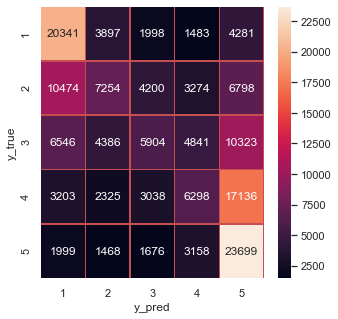

RESULTADOS TEST
              precision    recall  f1-score   support

           1       0.47      0.62      0.53      8000
           2       0.32      0.20      0.24      8000
           3       0.30      0.16      0.21      8000
           4       0.29      0.17      0.21      8000
           5       0.37      0.72      0.49      8000

    accuracy                           0.37     40000
   macro avg       0.35      0.37      0.34     40000
weighted avg       0.35      0.37      0.34     40000



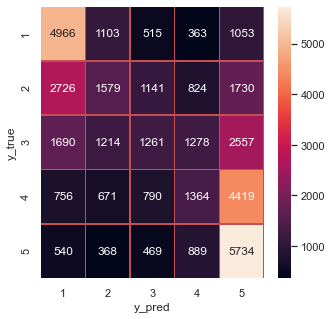

In [58]:
print('RESULTADOS TRAIN')
print(classification_report(y_train, y_train_pred))
confusion(y_train,y_train_pred)

print('RESULTADOS TEST')
print(classification_report(y_test, y_test_pred))
confusion(y_test,y_test_pred)

### 3.2 Random Forest Classifier

In [59]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 50, random_state=42)
rf.fit(x_train,y_train)

RandomForestClassifier(n_estimators=50, random_state=42)

In [60]:
y_train_pred_rf = rf.predict(x_train)
y_test_pred_rf = rf.predict(x_test)

RESULTADOS TRAIN
              precision    recall  f1-score   support

           1       0.99      0.99      0.99     32000
           2       0.99      0.98      0.98     32000
           3       0.98      0.97      0.98     32000
           4       0.96      0.97      0.96     32000
           5       0.97      0.97      0.97     32000

    accuracy                           0.98    160000
   macro avg       0.98      0.98      0.98    160000
weighted avg       0.98      0.98      0.98    160000



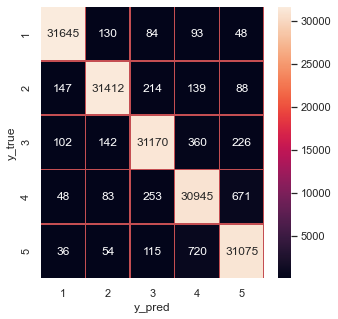

RESULTADOS TEST
              precision    recall  f1-score   support

           1       0.56      0.67      0.61      8000
           2       0.37      0.35      0.36      8000
           3       0.35      0.30      0.33      8000
           4       0.39      0.35      0.37      8000
           5       0.52      0.58      0.55      8000

    accuracy                           0.45     40000
   macro avg       0.44      0.45      0.44     40000
weighted avg       0.44      0.45      0.44     40000



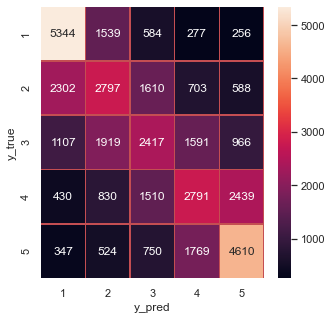

In [61]:
print('RESULTADOS TRAIN')
print(classification_report(y_train, y_train_pred_rf))
confusion(y_train,y_train_pred_rf)

print('RESULTADOS TEST')
print(classification_report(y_test, y_test_pred_rf))
confusion(y_test,y_test_pred_rf)

 - Aca podemos ver la importancia de los features que uso el modelo para clasificar

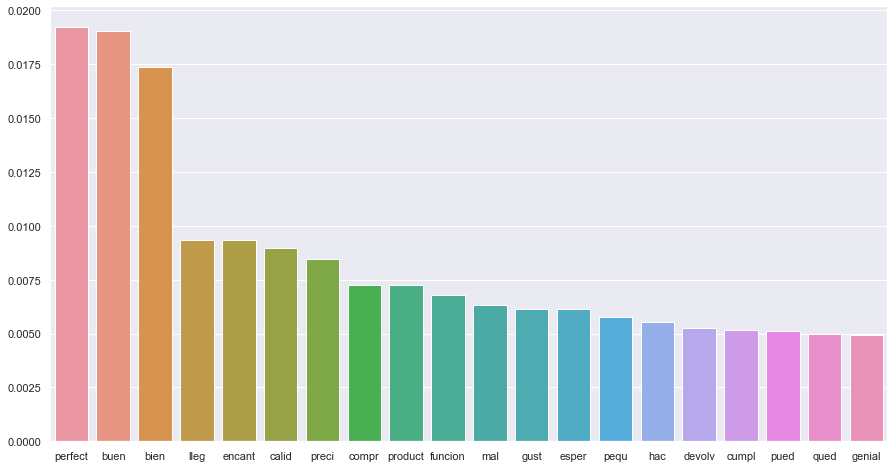

In [62]:
# Le preguntamos la importancia de cada feature (cada palabra)
importances = rf.feature_importances_
# Tomamos la lista de palabras
all_words_b = vectorizer_B.get_feature_names()
columns = all_words_b

# Ordenamos por importnacia y tomamos las 20 primeras
indices = np.argsort(importances)[::-1]
indices = indices[:20]
selected_columns = [columns[i] for i in indices]
selected_importances = importances[indices]

# Por ultimo graficamos
plt.figure(figsize = (15,8))
sns.barplot(selected_columns, selected_importances)
plt.show()

### 3.3 SVM

In [63]:
from sklearn.svm import LinearSVC

svc = LinearSVC(C = 1)
svc.fit(x_train,y_train)

LinearSVC(C=1)

In [64]:
y_train_pred_svm = svc.predict(x_train)
y_test_pred_svm = svc.predict(x_test)

RESULTADOS TRAIN
              precision    recall  f1-score   support

           1       0.57      0.72      0.64     32000
           2       0.43      0.39      0.41     32000
           3       0.41      0.31      0.36     32000
           4       0.45      0.36      0.40     32000
           5       0.55      0.70      0.61     32000

    accuracy                           0.50    160000
   macro avg       0.48      0.50      0.48    160000
weighted avg       0.48      0.50      0.48    160000



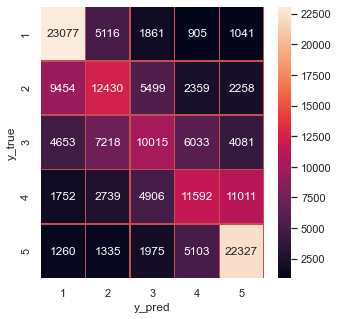

RESULTADOS TEST
              precision    recall  f1-score   support

           1       0.55      0.70      0.62      8000
           2       0.39      0.35      0.37      8000
           3       0.39      0.29      0.33      8000
           4       0.41      0.33      0.37      8000
           5       0.53      0.68      0.59      8000

    accuracy                           0.47     40000
   macro avg       0.45      0.47      0.46     40000
weighted avg       0.45      0.47      0.46     40000



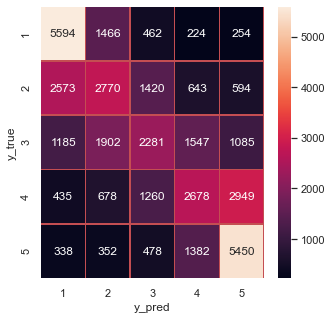

In [65]:
print('RESULTADOS TRAIN')
print(classification_report(y_train, y_train_pred_svm))
confusion(y_train,y_train_pred_svm)

print('RESULTADOS TEST')
print(classification_report(y_test, y_test_pred_svm))
confusion(y_test,y_test_pred_svm)

### - TITLE 

In [66]:
x1_train, x1_test, y1_train, y1_test = train_test_split(x1,y,test_size=0.2,random_state=42,stratify=y)

### 3.1 Naive Bayes - Benchmark

In [67]:
nb1 = GaussianNB()
nb1.fit(x1_train,y1_train)

GaussianNB()

RESULTADOS TRAIN
              precision    recall  f1-score   support

           1       0.47      0.51      0.49     32000
           2       0.42      0.11      0.17     32000
           3       0.39      0.09      0.14     32000
           4       0.26      0.06      0.09     32000
           5       0.29      0.92      0.44     32000

    accuracy                           0.34    160000
   macro avg       0.36      0.34      0.27    160000
weighted avg       0.36      0.34      0.27    160000



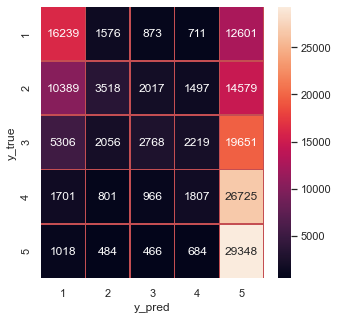

RESULTADOS TEST
              precision    recall  f1-score   support

           1       0.46      0.50      0.48      8000
           2       0.38      0.10      0.15      8000
           3       0.35      0.08      0.13      8000
           4       0.24      0.05      0.09      8000
           5       0.28      0.91      0.43      8000

    accuracy                           0.33     40000
   macro avg       0.34      0.33      0.26     40000
weighted avg       0.34      0.33      0.26     40000



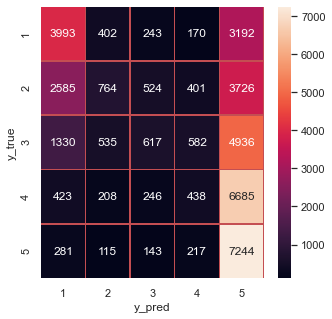

In [68]:
y1_train_pred = nb1.predict(x1_train)
y1_test_pred = nb1.predict(x1_test)


print('RESULTADOS TRAIN')
print(classification_report(y1_train, y1_train_pred))
confusion(y1_train,y1_train_pred)

print('RESULTADOS TEST')
print(classification_report(y1_test, y1_test_pred))
confusion(y1_test,y1_test_pred)

### 3.2 Random Forest Classifier

In [69]:
rf1 = RandomForestClassifier(n_estimators = 50, random_state=40)
rf1.fit(x1_train,y1_train)

RandomForestClassifier(n_estimators=50, random_state=40)

In [70]:
y1_train_pred_rf = rf1.predict(x1_train)
y1_test_pred_rf = rf1.predict(x1_test)

RESULTADOS TRAIN
              precision    recall  f1-score   support

           1       0.69      0.66      0.68     32000
           2       0.61      0.51      0.55     32000
           3       0.46      0.57      0.51     32000
           4       0.52      0.57      0.54     32000
           5       0.64      0.57      0.60     32000

    accuracy                           0.57    160000
   macro avg       0.59      0.57      0.58    160000
weighted avg       0.59      0.57      0.58    160000



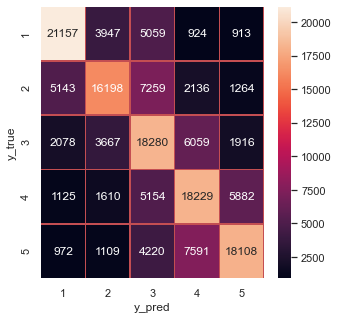

RESULTADOS TEST
              precision    recall  f1-score   support

           1       0.56      0.55      0.55      8000
           2       0.38      0.31      0.34      8000
           3       0.30      0.37      0.33      8000
           4       0.38      0.41      0.39      8000
           5       0.50      0.45      0.47      8000

    accuracy                           0.42     40000
   macro avg       0.42      0.42      0.42     40000
weighted avg       0.42      0.42      0.42     40000



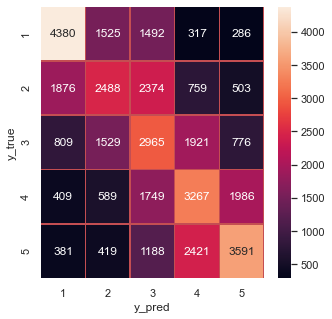

In [71]:
print('RESULTADOS TRAIN')
print(classification_report(y1_train, y1_train_pred_rf))
confusion(y1_train,y1_train_pred_rf)

print('RESULTADOS TEST')
print(classification_report(y1_test, y1_test_pred_rf))
confusion(y1_test,y1_test_pred_rf)

### 3.3 SVM

In [72]:
svc1 = LinearSVC(C = 1)
svc1.fit(x1_train,y1_train)

LinearSVC(C=1)

In [73]:
y1_train_pred_svm = svc1.predict(x1_train)
y1_test_pred_svm = svc1.predict(x1_test)

RESULTADOS TRAIN
              precision    recall  f1-score   support

           1       0.55      0.58      0.56     32000
           2       0.40      0.34      0.37     32000
           3       0.32      0.35      0.34     32000
           4       0.40      0.41      0.41     32000
           5       0.51      0.49      0.50     32000

    accuracy                           0.43    160000
   macro avg       0.44      0.43      0.43    160000
weighted avg       0.44      0.43      0.43    160000



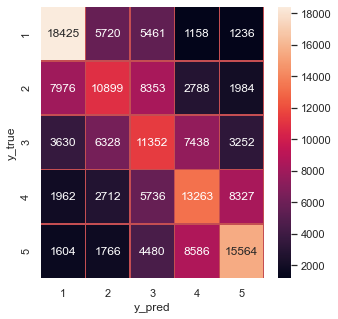

RESULTADOS TEST
              precision    recall  f1-score   support

           1       0.54      0.57      0.56      8000
           2       0.38      0.32      0.35      8000
           3       0.31      0.33      0.32      8000
           4       0.38      0.40      0.39      8000
           5       0.50      0.48      0.49      8000

    accuracy                           0.42     40000
   macro avg       0.42      0.42      0.42     40000
weighted avg       0.42      0.42      0.42     40000



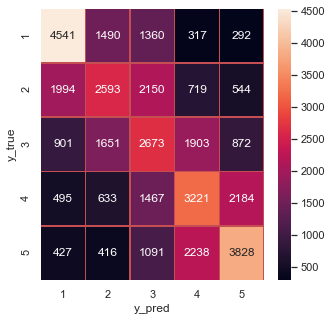

In [74]:
print('RESULTADOS TRAIN')
print(classification_report(y1_train, y1_train_pred_svm))
confusion(y1_train,y1_train_pred_svm)

print('RESULTADOS TEST')
print(classification_report(y1_test, y1_test_pred_svm))
confusion(y1_test,y1_test_pred_svm)

## Conlusiones de los modelos

A nivel general en los 6 modelos que hemos ejecutado tanto para BODY como para TITLE las metricas dan mejor en train que es test como es de esperar y nos indica la lógica. 

Hemos seleccionado como modelo bench al Naives Bayes (NB), el cual en terminos de metricas nos da los valores más bajos. Los otros dos modelos RF y SVM mejoran dichas metricas. 

Por otro lado buscando conclusiones respecto al análisis de TITLE y BODY el modelo que mejores metricas consigue en test es el SVM para el BODY. 

De los modelos expuestos se a buscado interpretarlos y correrlos modificacando sus hiperparametros llegando a los resultado expuestos que entendemos son los mejores y se detallan a constinuación

### - **BODY**
- **NB**: constituye nuestro modelo benckmark, donde eobservamos las metricas más bajas respecto a los otros modelos

- **RF**:

    -**Train**: vemos un marcado overfiting, con metricas todas superiores al 0.98, es decir, el modelo esta aprendiendo los datos de memoria. Además se observan metricas muy altas para los valores de 2,3 y 4 estrellas que por lo general son las más confusas.

    -**Test**: los valores parecen normalizarse, con un accuracy de 0.45 y una diagonal en la matriz de confusion que contiene el valor más alto de la fila. tambien vemos que las estrellas de 1 y 5 tiene las metricas más elevadas mientras que las estrellas intermedias (1,2,4) no presentan metricas superiores a 0.37, donde vemos que al modelo le cuesta clasificar. 

- **SVM**: 

    -**Train**: vemos el acuracy más alto logrado (0.5), un abuena diagonal en la matriz, pero mucha confusión en los valores intermadios de las estrellas
    
    -**Test**: las metricas en test disminusción un poco respecto a train y seguimos viendo confusión en los valores intermedios. Igualmente es el valor en test (0.47) más alto de accuracy obtenido y la diagonal de la matriz tiene los valores más altos de la fila. 

### - **TITLE**
- **NB**: constituye nuestro modelo benchmark, donde eobservamos las metricas más bajas respecto a los otros modelos

- **RF**: 

    -**Train**:Como era una posibilidad que se vio durante el EDA que el titulo fuese un muy buen predictor, este RF obtiene el mejor occuracy en train (0.57) y todos valores encima de 0.5 en las clasificaciones intermedias. 
    
    -**Test**: a pesar del muy buen resultado en train el test baja a un accuracy de 0.42 y vemos imporntates niveles de confisión en los valores 2, 3 y 4. 

- **SVM**: 

    -**Train**: las metricas son inferiores al SVM aplicado sobre el BODY
    
    -**Test**: las metricas son inferiores al SVM aplicado sobre el BODY
    
    
### - **FINALMENTE**

El modelo que esta funcionando mejor en las instacia de test según todo el análisis expuesto y las conclusiones anteriores es el SVM aplicado sobre el BODY de las review.

Interpreto que por más de variar los hiperparametros de los modelos, las metricas no mejorar sustancialmente debido principalmente a la cantidad de vocabulario del data set y la riqueza o diferentes maneras de expresiones que tiene el idioma español. 

### - **Proximos Pasos y resultados esperados**

 1. Buscar probar un nuevo modelo no utilizado hasta el momento. El modelo que voy a buscar utilzar es XGBOOST, por los siguientes motivos
 
     - Investigando doy con que es un modelo muy popular y de amplia aplicación no visto en el presente curso el cual me gustaría invertir tiempo en conocer.
     - Modelo reconocido por su velocidad de ejecución y rendimiento
     - Como entrada admite una sparse matrix que es nuestro caso (Sparsity: acepta entradas dispersas tanto para el reforzador de árboles como para el reforzador lineal), y está optimizado para entradas dispersas
     - Utiliza procesamiento en paralelo, poda de árboles, manejo de valores perdidos y regularización (optimización que penaliza la complejidad de los modelos) para evitar en lo posible sobreajuste o sesgo del modelo.
 
 
 2. ¿Hay algo que te gustaría investigar o probar?
 
 - Trabajar con el data set haciendo foco en las 15 categorías de productos que responden al 80% de las review y buscar si existen palabras especificas para cada categoría o grupo de categorías. Esto posiblemente implique probar modelos por categorías y evaluarlos. 
 En esto punto planteo dividir el problema y analizar las reviews por categoría para ver si logro mejorar la performance de los modelos viendo categorías individuales o grupos de categorías que se califiquen de manera similar
 
 3. ¿Valdrá la pena convertir el problema de Machine Learning en un problema binario? Es decir, asignar únicamente las etiquetas Positiva y Negativa a cada crítica y hacer un modelo que, en lugar de predecir las estrellas, prediga esa etiqueta. Pensar en qué situación puede ser útil. ¿Esperas que el desempeño sea mejor o peor?

Considero que sería una muy buena opción a probar y evaluar. Solamente que no pondría los extremos 'positivo' y 'negativo' si no que transformaría a las estrellas en las dos opciones expuestas a continuación y evaluaria resultados de los modelos, 
 
Opción 1:

 - 1 => Positivo
 - 2, 3 y 4 => Neutro. Aca es donde hemos visto más cuesta al modelo diferenciar
 - 5 => negativo

Opción 2

 - 1 y 2 => Positivo
 - 3 => Neutro
 - 4 y 5 => negativo 
 
Me parece que si puede mejorar el desempeño. El problema que estaríamos cambiando la logica en cierta manera de como ya esta clasificado el dataset que tiene 5 posibilidades cambiandolo a 3, es decir, tendriamos una nueva verión del data set. Por otro lado si este fuese el sistema de calificación de un cliente habría que hacer una modificación más profunda sobre como los usuarios clasifican, ya que el sistema debería mutar de uno de 5 opciones a uno de 3 a lahora de clasificar. 
 

